In [1]:
import re
import os
import time
import pymysql
import requests
import selenium
import pandas as pd
from tqdm import tqdm
import koreanize_matplotlib
from bs4 import BeautifulSoup as bs
from gensim.models import CoherenceModel
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from selenium import webdriver
import matplotlib.pyplot as plt
from collections import Counter
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from sklearn.decomposition import LatentDirichletAllocation
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from sqlalchemy import create_engine, text
from dbio import load_data, to_db

newuser1


In [2]:
#!pip install pymysql

# 1. 핀테크 지원센터 홈페이지 -> 알림마당 > 핀테크 정보 > 핀테크 뉴스에 접속

In [3]:
params = dict(board_id=6,menu_id=6500,miv_pageNo=1)
url = "https://fintech.or.kr/web/board/boardContentsListPage.do"
r = requests.get(url, params=params)
print(r.url)
soup = bs(r.text,'html')

https://fintech.or.kr/web/board/boardContentsListPage.do?board_id=6&menu_id=6500&miv_pageNo=1


# 2. 일자별로 있는 [11/18 핀테크 주요뉴스] 안에 있는 뉴스 제목과 원문 link 수집 

In [4]:
url = "https://fintech.or.kr/web/board/boardContentsList.do"
r = requests.get(url, params=params)
print(r.url)
soup = bs(r.text,'html')

https://fintech.or.kr/web/board/boardContentsList.do?board_id=6&menu_id=6500&miv_pageNo=1


In [5]:
soup.select_one(".boardlist  .txtl > a").get('href')

"javascript:contentsView('bf1b44ca61d74074a455cf21e180451c')"

In [6]:
soup.select_one(".boardlist  .txtl > a").text

'[경기도] 미래콘텐츠 성과공유회(AXR)에 초대합니다. (11/20(목) ~ 21(금))'

In [7]:
# import requests

# api_url = "https://fintech.or.kr/web/user/homepageMenuList.do?up_menu_id=6000"
# res = requests.get(api_url)
# print(res.json())

In [8]:
news_list = []


options = Options()
options.add_experimental_option("detach", True)
options.add_argument("start-maximized")
options.add_argument("Chrome/141.0.0.0")
options.add_argument("lang=ko_KR")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
    )


for num in range(1,20):
    params = dict(miv_pageNo=f"{num}",mode='W',board_id=6,searchkey='I')
    url = "https://fintech.or.kr/web/board/boardContentsList.do"
    r = requests.get(url, params=params)
#    print(r.url)
    soup = bs(r.text,'html')
    
    #웹브라우저에서 url열기
    driver.get(r.url)
    
    news_list.append(soup.select("a.txtl"))
    

In [9]:
news_text = []
full_href = []

for paige in news_list:
    for element in paige:
        if "핀테크 주요뉴스" in element.text:
            news_text.append(element.text.strip())
            full_href.append(element.get('href'))
        else:
            pass

In [10]:
code = []
for c in full_href[::]:
    c = c.replace("javascript:contentsView('","").replace("')","")
    code.append(c)

In [11]:
# 날짜별 핀테크 뉴스 수집
all_news = []
all_date = []
for num2 in code:
    url2 = "https://fintech.or.kr/web/board/boardContentsView.do"
    payload2= dict(miv_pageNo=1,contents_id=f"{num2}",board_id=6)
    r2 = requests.get(url2, params=payload2)
    print(r2.url,end="\r")
    soup2 = bs(r2.text,'lxml')
    date = soup2.select_one("div > div.board_detail > div.title_box > ul > li").text.replace("작성일 : ","")
    all_date.append(date)
    all_news.append(soup2.select("tbody  td > a"))

In [12]:
len(all_date)

226

# 3. 원문링크로 들어가서 뉴스 본문을 2025년 1월 2일까지  수집 후(약 18page) 데이터 베이스에 저장 

In [13]:
import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import pandas as pd

# code 리스트는 이미 있다고 가정
# code = [...]

final_news_link = []
final_news_date = []
final_news_title = []
final_news_text = []

for num2 in tqdm(code, desc="뉴스 링크·날짜·제목 수집 중"):
    url2 = "https://fintech.or.kr/web/board/boardContentsView.do"
    payload2 = dict(miv_pageNo=1, contents_id=f"{num2}", board_id=6)

    try:
        r2 = requests.get(url2, params=payload2, timeout=5)
        r2.raise_for_status()
        soup2 = bs(r2.text, 'lxml')

        # 1) 날짜
        date_tag = soup2.select_one("div > div.board_detail > div.title_box > ul > li")
        date = date_tag.text.replace("작성일 : ", "").strip() if date_tag else "날짜_없음"

        # 2) 링크 & 제목
        link_items = soup2.select("tbody td > a")

        for item in link_items:
            link = item.get("href")
            title = item.text.strip()

            if link:
                final_news_link.append(link)
                final_news_date.append(date)
                final_news_title.append(title)

                # 3) 뉴스 본문
                try:
                    r3 = requests.get(link, timeout=5)
                    r3.raise_for_status()
                    news_soup = bs(r3.text, 'lxml')
                    text = news_soup.get_text(strip=True)
                except:
                    text = "텍스트_추출_실패"

                final_news_text.append(text)

    except requests.exceptions.RequestException as e:
        tqdm.write(f"⚠ 요청 실패 code {num2} | 오류: {e}")
        continue


# =======================================
# 📌 결과를 DataFrame으로 만들기
# =======================================

cols = ["날짜", "제목", "원문링크", "뉴스본문"]
values = (final_news_date, final_news_title, final_news_link, final_news_text)

result = {}
for col, val in zip(cols, values):
    result[col] = val

df = pd.DataFrame(result)

print("\n📌 DataFrame 생성 완료!")
print(df.head())

# =======================================
# 📌 DB에 저장
# =======================================

to_db("2025fintech_news", "2025fintech_news", df)

print("\n🎉 데이터베이스 저장 완료!")

뉴스 링크·날짜·제목 수집 중: 100%|████████████████████████████████████████████████████| 226/226 [46:22<00:00, 12.31s/it]



📌 DataFrame 생성 완료!
           날짜                                                 제목  \
0  2025-11-21  [한국핀테크지원센터] 2025 핀테크 전문가(개발자) 과정 ‘FinBoost Aca...   
1  2025-11-21  [한국핀테크산업협회] 네트워킹 행사 '핀테크 커넥팅 데이 2025' 개최(11.26...   
2  2025-11-21  [한국핀테크지원센터] (온라인) 핀테크를 통한 금융 AI 트렌드와 혁신 사례 교육생...   
3  2025-11-21  [한국핀테크지원센터] 2025년 핀테크기업 온라인 채용관 (사람인 saramin) ...   
4  2025-11-21  금감원, IMA·발행어음 증권사 임원 대상 간담회 개최… 모험자본·리스크·소비자보호 당부   

                                                원문링크  \
0  https://fintech.or.kr/web/board/boardContentsV...   
1  https://fintech.or.kr/web/board/boardContentsV...   
2  https://fintech.or.kr/web/board/boardContentsV...   
3  https://fintech.or.kr/web/board/boardContentsV...   
4  https://n.news.naver.com/mnews/article/029/000...   

                                                뉴스본문  
0  핀테크 포털 - 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기..본문 바로가기로그인...  
1  핀테크 포털 - 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기..본문 바로가기로그인...  
2  핀테크 포털 - 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기..본문 바로가기로그인...  
3  핀테크 포털 - 한국

In [14]:
# to_db("2025fintech_news", "2025fintech_news", df)

# print("\n🎉 데이터베이스 저장 완료!")

In [57]:
# 뉴스링크
# news_link = [item.get("href") for row in all_news for item in row]
# len(news_link)

In [58]:
# 뉴스 제목
# news_text = [item.text for row in all_news for item in row]
# len(news_text)

In [59]:
#  # 뉴스 텍스트
# r3 = requests.get(link, timeout=5)
# r3.raise_for_status()
# news_soup = bs(r3.text, 'lxml')
# text = news_soup.select(".nbd_table")
# text

In [60]:
# content = news_soup.select_one("#dic_area") or news_soup.select_one("div.content")
# text = content.get_text(" ", strip=True) if content else news_soup.get_text(" ", strip=True)
# text

In [61]:
# # 뉴스링크
# news_link = [item.get("href") for row in all_news for item in row]
# len(news_link)
# # 뉴스 제목
# news_text = [item.text for row in all_news for item in row]
# len(news_text)
# # 뉴스 텍스트
# news_text = []
# for index,l in enumerate(news_link):
#     print(f"인덱스: {index}, 값: {l}",end='\r')
#     r3 = requests.get(l)
#     news = bs(r3.text,'html')
#     news_text.append(news.get_text(strip=True))

# 4. 데이터 베이스에 저장된 뉴스를 데이터프레임으로 불러와서 텍스트 전처리, Wordcloud, LDA 토픽 모델링

In [2]:
from wordcloud import WordCloud

In [3]:
sql_news_df = load_data("2025fintech_news","2025fintech_news")
sql_news_df

NameError: name 'load_data' is not defined

In [7]:
len(sql_news_df)

11729

In [8]:
# 텍스트 처리
def text_clean(x):
    # 한글 영문대소문자, 숫자만 남기고 모두 제거
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]'," ",x)
    cleaned = cleaned.replace("  "," ").replace("  "," ").strip()
    return cleaned

In [9]:
sql_news_df['뉴스본문'] = sql_news_df['뉴스본문'].apply(text_clean)

In [10]:
text_data =  sql_news_df['뉴스본문'].fillna('').astype(str).tolist()

In [11]:
def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

chunks = chunk_list(text_data, 1000)   # 1000개씩 나누기

full_text_list = [" ".join(chunk) for chunk in chunks]

In [12]:
chunks = list(chunk_list(text_data, 50))

In [13]:
full_text_list = [" ".join(chunk) for chunk in chunks]

In [14]:
 #MeCab 명사 추출
from konlpy.tag import Mecab
mecab = Mecab()

In [15]:
all_nouns = []

In [16]:
for ft in full_text_list:
    nouns = mecab.nouns(ft)      # 각 청크에서 명사 추출
    all_nouns.extend(nouns)  

In [57]:
len(all_nouns)

27717744

In [18]:
stopwords = set(['지원','센터','뱅킹','동관','기사','검색','이재명','구독','특검','기자','언론사','부부','김건희'])

In [19]:
filtered = [word for word in nouns if len(word) > 1 and word not in stopwords]
filtered

['은행',
 '슈퍼',
 '경쟁',
 '치열',
 '본문',
 '뉴스',
 '엔터',
 '스포츠',
 '날씨',
 '프리미엄',
 '정치',
 '경제',
 '사회',
 '생활',
 '문화',
 '과학',
 '세계',
 '랭킹',
 '신문',
 '피니언',
 '체크',
 '알고리즘',
 '내정',
 '정보',
 '비즈',
 '워치',
 '비즈',
 '워치',
 '비즈',
 '워치',
 '뉴스',
 '주요',
 '뉴스',
 '비즈',
 '워치',
 '해지',
 '안내',
 '주요',
 '선정',
 '은행',
 '슈퍼',
 '경쟁',
 '치열',
 '노명현',
 '노명현',
 '노명현',
 '구독자',
 '응원',
 '입력',
 '오전',
 '원문',
 '추천',
 '정보',
 '흥미',
 '진진',
 '공감',
 '분석',
 '후속',
 '강추',
 '댓글',
 '텍스트',
 '음성',
 '변환',
 '서비스',
 '사용',
 '성별',
 '남성',
 '여성',
 '속도',
 '느림',
 '보통',
 '빠름',
 '통신망',
 '이용',
 '음성',
 '재생',
 '별도',
 '데이터',
 '통화료',
 '부과',
 '본문',
 '시작',
 '글자',
 '크기',
 '변경',
 '단계',
 '단계',
 '보통',
 '단계',
 '단계',
 '단계',
 '최대',
 '인쇄',
 '금융',
 '우리',
 '농협',
 '기업',
 '은행',
 '개편',
 '하나',
 '은행',
 '가구',
 '신탁',
 '출시',
 '신한',
 '광주',
 '은행',
 '성장',
 '협약',
 '체결',
 '우리',
 '금융',
 '슈퍼',
 '경쟁',
 '참전',
 '우리',
 '금융',
 '지주',
 '그룹',
 '핵심',
 '서비스',
 '유니버설',
 '우리',
 '출시',
 '전면',
 '구축',
 '우리',
 '금융',
 '슈퍼',
 '기존',
 '우리은행',
 '우리',
 '업그레이드',
 '유니버설',
 '기능',
 '탑재',
 '유니버설',
 '은행',
 '예금',


In [20]:
word_freq = Counter(filtered)

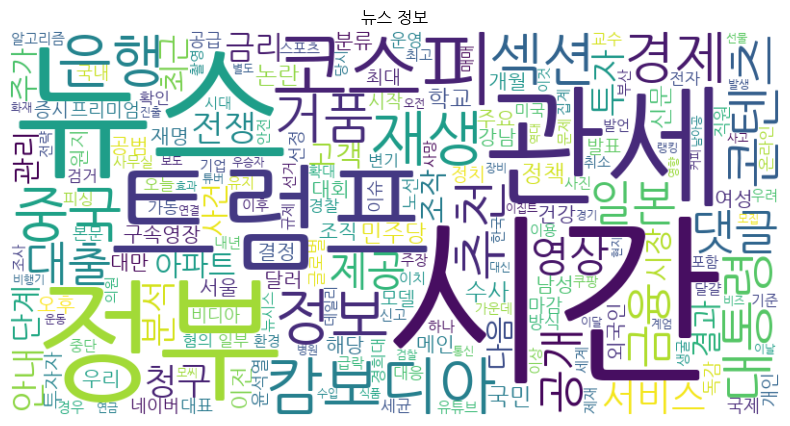

In [21]:
wc = WordCloud(
    font_path='NanumGothic.ttf',
    background_color= 'white',
    width=800,
    height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.title("뉴스 정보")
plt.show()

In [54]:
print(len(filtered))

58866


In [46]:
sql_news_df['뉴스본문']

0        핀테크 포털 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기 본문 바로가기로그인회원가...
1        핀테크 포털 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기 본문 바로가기로그인회원가...
2        핀테크 포털 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기 본문 바로가기로그인회원가...
3        핀테크 포털 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기 본문 바로가기로그인회원가...
4        금감원 IMA 발행어음 증권사 임원 대상 간담회 개최 모험자본 리스크 소비자보호 당...
                               ...                        
11724    수렁에 빠진 중국 경제  몰락 중산층 2000만명 우버 택시로 몰렸다 본문 바로가기...
11725    관세 폭탄 때문에 내년엔 더 비싸 생필품 가전 등 사재기 열풍 부는 본문 바로가기N...
11726    구글 메타 등과 AI칩 합작 브로드컴 엔비디아 대항마로본문 바로가기NAVER뉴스엔터...
11727    중국의 중동 동남아 통한 AI 반도체 우회 조달도 막는다본문 바로가기NAVER뉴스엔...
11728    핀테크 포털 한국핀테크지원센터메뉴 건너띄기상단메뉴 바로가기 본문 바로가기로그인회원가...
Name: 뉴스본문, Length: 11729, dtype: object

# LDA 토픽 모델링

In [55]:
import math

n = 10000  # 문서당 단어 개수
docs = [filtered[i:i+n] for i in range(0, len(filtered), n)]
print(len(docs))

6


In [56]:
def tokenize_texts(text):
    return [[word for word in mecab.nouns(doc) if len(word) > 1]for doc in texts]

In [26]:
def find_optimal_topics(docs, start=2, end=8):
    # texts는 문자열 리스트
    tokenized_texts = tokenize_texts(texts)
    if not tokenized_texts:
        return start
    # gensim으로 Bow(ㅠ숫자로 인코딩 된 단어 모음)
    dictionary = corpora.Dictionary(tokenized_texts)
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    
    try:
        doc_term_matrix = vectorizer.fit_transform(tokenized_texts)
    except:
        print("벡터화중 오류발생, 기본 토픽 수 2개 반환")
        return start
    
    best_score = -1
    best_n = start
    
    # LDA 분석
    for n_topics in range(start, end+1):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(doc_term_matrix)
        
        feature_names = vectorizer.get_feature_names_out()
        # 상위 10개의 단어를 순서대로 추출
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in lda_model.components_]
        
        # 응집도 계산
        cm = CoherenceModel(topics=topics, texts=tokenized_texts, dictionary=dictionary, coherence="c_v")
        score = cm.get_coherence()
        print(f"토픽수: {n_topics}, Coherence Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_n = n_topics
    print(f"최적 토픽수: {best_n} (score: {best_score:.4f})")
    return best_n

In [52]:
documents = [' '.join(doc) for doc in docs]

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
doc_matrix = vectorizer.fit_transform(documents)

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(doc_matrix)

words_feat = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top = [words_feat[idx] for idx in topic.argsort()[-10:]]
    print(f"Topic {i}: {top}")

Topic 0: ['거품', '대통령', '서비스', '캄보디아', '뉴스', '콘텐츠', '코스피', '트럼프', '정부', '관세']
Topic 1: ['공개', '섹션', '아파트', '결과', '댓글', '일본', '중국', '재생', '뉴스', '시간']


# 2025년 핀테크 뉴스에서 가장 많이 다룬 주제를 찾고 서비스 기획 아이디어 제시하기